In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import random
import shutil
from matplotlib.image import imread

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import time
import seaborn as sns
import pathlib
import random

# import DCGAN as gan

import json

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from pathlib import Path

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

# Data preprocess

In [5]:
IMG_DIR = '../PokemonData'

In [6]:
def data_extractor(class_pct, train_pct, val_pct, test_pct):
    dirs = os.listdir(IMG_DIR)
    sub_classes = random.sample(dirs,int(len(dirs)*class_pct))

    for cla in sub_classes:
        os.system('mkdir "train/'+cla+'"')
        os.system('mkdir "test/'+cla+'"')
        os.system('mkdir "val/'+cla+'"')
        os.system("find train/"+cla+" -name '*.*' -type f -delete")
        os.system("find val/"+cla+" -name '*.*' -type f -delete")
        os.system("find test/"+cla+" -name '*.*' -type f -delete")

        temp_files = os.listdir(os.path.join(IMG_DIR,cla))

        files = [f for f in temp_files if isfile(os.path.join(IMG_DIR, cla,f))]
        
        train_files = random.sample(files,int(len(files)*(train_pct+val_pct+test_pct)))
        val_files = random.sample(train_files,int(len(files)*(val_pct+test_pct)))
        test_files = random.sample(val_files,int(len(files)*test_pct))
        
        train_files = [x for x in train_files if x not in val_files]
        val_files = [x for x in val_files if x not in test_files]
        
        for file in train_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('train',cla,file))
        for file in val_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('val',cla,file))
        for file in test_files:
            shutil.copy(os.path.join(IMG_DIR,cla,file), os.path.join('test',cla,file))

In [7]:
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def create_dataset (root):
    all_image_paths = list(root.glob('*/*.jpg'))
    all_image_paths2 = list(root.glob('*/*.jpeg'))

    all_image_paths.extend(all_image_paths2)
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)

    image_count = len(all_image_paths)

    print("The image count is %d" % image_count)
    label_names = sorted(item.name for item in root.glob('*/') if item.is_dir())

    label_to_index = dict((name, index) for index, name in enumerate(label_names))

    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in all_image_paths]

    print("First 10 labels indices: ", all_image_labels[:10])

    steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
    print(steps_per_epoch)

    paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    image_ds = paths_ds.map(load_and_preprocess_image)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)
    

    ds = image_label_ds.shuffle(buffer_size=image_count)
    ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return ds

def create_train_val_test_folder():
    os.system("mkdir train")
    os.system("mkdir test")
    os.system("mkdir val")


def clean_images():
    os.system("rm -r train/* test/* val/*")
    os.system("find train/ -name '*.*' -type f -delete")
    os.system("find val/ -name '*.*' -type f -delete")
    os.system("find test/ -name '*.*' -type f -delete")

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)    


In [74]:
SampleSize= 1
TrainSize = 0.7
TestSize = 0.2
ValSize= 0.1

create_train_val_test_folder()
data_extractor(1, 0.7, 0.2, 0.1)

In [8]:
data_root = Path('./train')
Test_root = Path('./test')
val_root = Path('./val')

In [9]:
train_ds = create_dataset (data_root)
val_ds = create_dataset (val_root)

The image count is 4613
First 10 labels indices:  [61, 39, 62, 23, 121, 98, 70, 97, 97, 83]
145.0
The image count is 1335
First 10 labels indices:  [82, 108, 14, 6, 100, 119, 62, 40, 74, 101]
42.0


# Build Model

In [10]:
EPOCH = 100
image_shape = (192,192,3)

## Baseline model

In [78]:
def build_baseline():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(150,activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

    return model


In [79]:
baseline_model = build_baseline()
baseline_history =  baseline_model.fit(train_ds, epochs=30, validation_data = val_ds, verbose=0)

In [80]:
hist_df = pd.DataFrame(baseline_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
20,0.002381,0.999566,6.272558,0.345318
21,0.002085,0.999350,6.546325,0.343820
22,0.003920,0.999566,6.293329,0.346816
23,0.001176,0.999783,6.420732,0.350562
24,0.000811,0.999783,6.614531,0.353558
25,0.001369,0.999566,6.570898,0.344569
26,0.001919,0.999566,6.387856,0.344569
27,0.056746,0.983308,8.019175,0.226217
28,0.604548,0.844786,5.387759,0.299625
29,0.135370,0.960546,6.108543,0.331835


<AxesSubplot:>

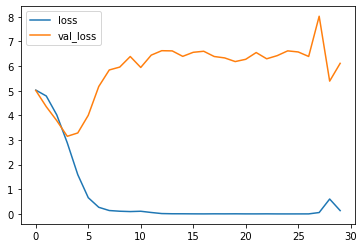

In [81]:
baseline_model.save_weights("./model_weight/baseline.h5")

loss_history = pd.DataFrame(baseline_history.history)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

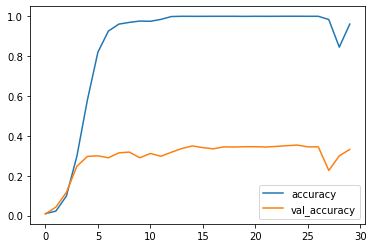

In [82]:
loss_history[['accuracy','val_accuracy']].plot()

## Learning Rate Decay

In [83]:
initial_rate = 0.001
decay_step = 100
decay_rate = 0.96

def Deacy():
    model = Sequential()

    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(64,activation='relu'))

    model.add(Dense(16,activation='relu'))

    model.add(Dense(150,activation='softmax'))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_rate,
    decay_steps=decay_step,
    decay_rate=decay_rate,
    staircase=True)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])

    return model

In [84]:
Deacy_model = Deacy()
Deacy_history =  Deacy_model.fit(train_ds, epochs=30, validation_data = val_ds, verbose=0)

In [85]:
hist_df = pd.DataFrame(Deacy_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
20,0.171847,0.964015,8.144903,0.232959
21,0.157137,0.967700,8.432899,0.229963
22,0.132761,0.974203,8.670505,0.227715
23,0.114822,0.976805,9.052227,0.230712
24,0.100307,0.981791,9.348066,0.227715
25,0.090875,0.983308,9.584896,0.227715
26,0.081919,0.985476,9.867682,0.227715
27,0.072565,0.987210,10.194777,0.226217
28,0.067722,0.987427,10.588598,0.218727
29,0.058034,0.990462,10.731627,0.229213


<AxesSubplot:>

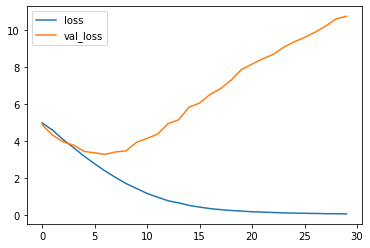

In [86]:
Deacy_model.save_weights("./model_weight/Deacy.h5")

loss_history = pd.DataFrame(Deacy_history.history)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

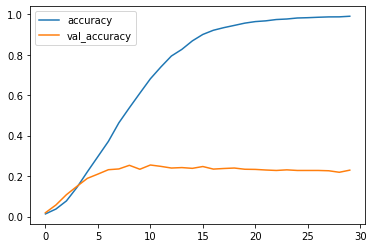

In [87]:
loss_history[['accuracy','val_accuracy']].plot()

## Learning Rate Reduction

In [88]:
def Reduct():
    model = Sequential()

    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(64,activation='relu'))

    model.add(Dense(16,activation='relu'))

    model.add(Dense(150,activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [89]:
Reduct_model = Reduct()
Reduct_history =  Reduct_model.fit(train_ds, epochs=30, validation_data = val_ds, verbose=0)

In [90]:
hist_df = pd.DataFrame(Reduct_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
20,0.133492,0.959679,9.467960,0.251685
21,0.112605,0.970301,9.502872,0.239700
22,0.093959,0.971168,9.614543,0.248689
23,0.111875,0.965315,9.476501,0.240449
24,0.119521,0.968350,10.005835,0.250187
25,0.082357,0.976588,10.350773,0.240449
26,0.070837,0.980273,9.969790,0.256929
27,0.048240,0.987860,10.761018,0.262921
28,0.040425,0.988944,10.653797,0.253184
29,0.055834,0.985909,10.318395,0.265918


In [91]:
Reduct_model.save_weights("./model_weight/reduct.h5")

<AxesSubplot:>

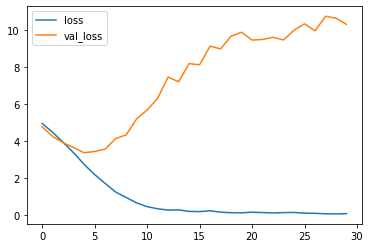

In [92]:
loss_history = pd.DataFrame(Reduct_history.history)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

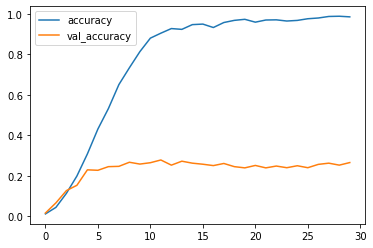

In [93]:
loss_history[['accuracy','val_accuracy']].plot()

## Dropout

In [94]:
def DropoutModel():
    model = Sequential()

    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(rate=0.2))

    model.add(Dense(16,activation='relu'))
    model.add(Dropout(rate=0.2))

    model.add(Dense(150,activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [95]:
Dropout_model = DropoutModel()
Dropout_history =  Dropout_model.fit(train_ds, epochs=150, validation_data = val_ds, verbose=0)

In [96]:
Dropout_model.save_weights("./model_weight/dropout.h5")

In [97]:
hist_df = pd.DataFrame(Dropout_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
140,1.238627,0.627141,9.238233,0.176779
141,1.148776,0.649252,9.367373,0.188764
142,1.204527,0.637329,9.331651,0.183521
143,1.160220,0.653371,9.892102,0.177528
144,1.185677,0.639714,9.662309,0.181273
145,1.238591,0.624106,10.063887,0.186517
146,1.227933,0.641015,9.570471,0.176030
147,1.195643,0.640147,9.537419,0.189513
148,1.240374,0.632994,9.808903,0.184270
149,1.159878,0.656189,10.018388,0.182772


<AxesSubplot:>

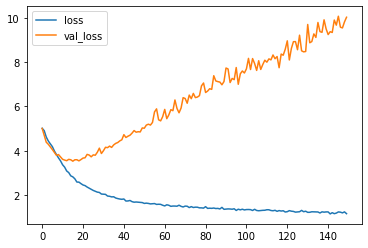

In [98]:
loss_history = pd.DataFrame(Dropout_history.history)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

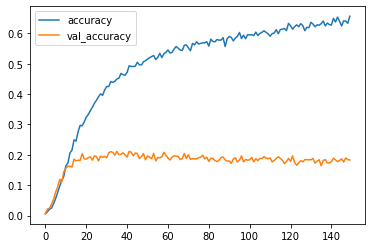

In [99]:
loss_history[['accuracy','val_accuracy']].plot()

## Data Argumentation

In [16]:
from tensorflow.keras import layers

In [101]:
def Data_aug():
    data_augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
        ]
    )

    model = Sequential()

    model.add(data_augmentation)
    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(64,activation='relu'))

    model.add(Dense(16,activation='relu'))

    model.add(Dense(150,activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

    return model

In [102]:
'''Data_aug_model = Data_aug()
Data_aug_history =  Data_aug_model.fit(train_ds, epochs=150, validation_data = val_ds, verbose=0)'''

'Data_aug_model = Data_aug()\nData_aug_history =  Data_aug_model.fit(train_ds, epochs=150, validation_data = val_ds, verbose=0)'

In [103]:
'''Data_aug_model.save_weights("./model_weight/Data_aug.h5")'''

'Data_aug_model.save_weights("./model_weight/Data_aug.h5")'

In [104]:
''''hist_df = pd.DataFrame(Data_aug_history.history) 
hist_df.tail(10)''''

SyntaxError: EOL while scanning string literal (<ipython-input-104-f70ae9d02e5a>, line 2)

<AxesSubplot:>

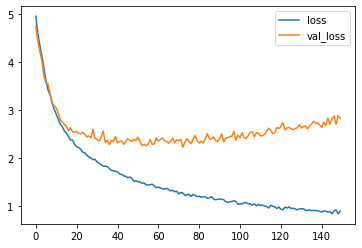

In [ ]:
'''loss_history = pd.DataFrame(Data_aug_history.history)

loss_history[['loss','val_loss']].plot()'''

<AxesSubplot:>

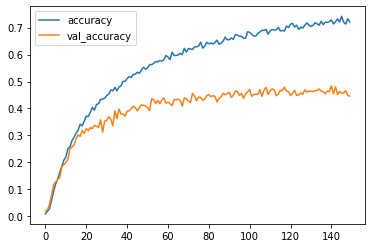

In [ ]:
'''loss_history[['accuracy','val_accuracy']].plot()'''

## GAN

In [11]:
GAN_path = '../savedData'

In [ ]:
os.system("mkdir gan_train")

0

In [ ]:
dirs = os.listdir(GAN_path)
sub_classes = random.sample(dirs,int(len(dirs)))

for cla in sub_classes:
    os.system('mkdir "gan_train/'+cla+'"')
    os.system("find gan_train/"+cla+" -name '*.*' -type f -delete")

    temp_files = os.listdir(os.path.join(GAN_path,cla))
    train_files = [f for f in temp_files if isfile(os.path.join(GAN_path, cla,f))] 
        
    for file in train_files:
        shutil.copy(os.path.join(GAN_path,cla,file), os.path.join('gan_train',cla,file))

In [ ]:
train_dir = "./train"
dirs = os.listdir(train_dir)
sub_classes = random.sample(dirs,int(len(dirs)))

for cla in sub_classes:
    temp_files = os.listdir(os.path.join(train_dir,cla))
    train_files = [f for f in temp_files if isfile(os.path.join(train_dir, cla,f))]        
    
    for file in train_files:
        shutil.copy(os.path.join(train_dir,cla,file), os.path.join('gan_train',cla,file))

In [13]:
gan_data_root = Path('./gan_train')

In [14]:
gan_train_ds = create_dataset (gan_data_root)

The image count is 10013
First 10 labels indices:  [118, 132, 42, 87, 143, 95, 88, 14, 111, 45]
313.0


In [ ]:
gan_model = build_baseline()
gan_history =  gan_model.fit(gan_train_ds, epochs=30, validation_data = val_ds, verbose=0)

In [ ]:
hist_df = pd.DataFrame(gan_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
20,0.100985,0.976812,5.983919,0.274085
21,0.163377,0.960520,5.740689,0.315907
22,0.052618,0.986507,7.399418,0.297984
23,0.025962,0.994703,5.722193,0.330844
24,0.013041,0.996802,7.477231,0.294996
25,0.016619,0.996702,7.334221,0.300224
26,0.012469,0.996802,7.419091,0.301718
27,0.019490,0.995202,8.340942,0.287528
28,0.067323,0.986107,7.713514,0.276326
29,0.031866,0.993803,7.137740,0.289022


<AxesSubplot:>

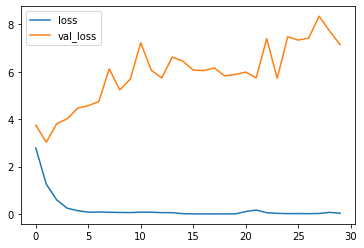

In [ ]:
gan_model.save_weights("./model_weight/gan.h5")

loss_history = pd.DataFrame(gan_history.history)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

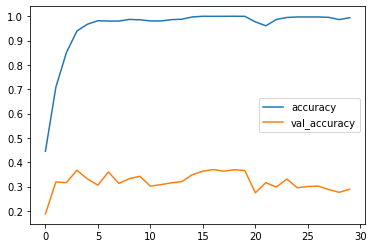

In [ ]:
loss_history[['accuracy','val_accuracy']].plot()

## Going to a deeper Network

### Resnet

In [148]:

def ResNet():
        resnet50 = tf.keras.applications.resnet.ResNet50(
                input_shape=image_shape,
                include_top=False,
                weights=None)

        model = tf.keras.Sequential([
        resnet50,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(150, activation = 'softmax')])

        model.compile(
                optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
        
        return model

ResNet_model = ResNet()
ResNet_history =  ResNet_model.fit(train_ds, epochs=100, validation_data = val_ds, verbose=0)

In [149]:
ResNet_model.save_weights("./model_weight/resnet50.h5")

In [150]:
hist_df = pd.DataFrame(ResNet_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
90,0.187127,0.949491,2.386019,0.582022
91,0.047619,0.987644,2.626435,0.558801
92,0.013418,0.997182,1.678044,0.684644
93,0.047615,0.988511,2.105460,0.623970
94,0.029565,0.991979,3.674185,0.510112
95,0.022531,0.993280,1.949779,0.653184
96,0.085680,0.977238,1.936498,0.632210
97,0.073457,0.978105,1.786853,0.667416
98,0.035329,0.990245,1.767843,0.666667
99,0.029831,0.991979,1.798710,0.683146


<AxesSubplot:>

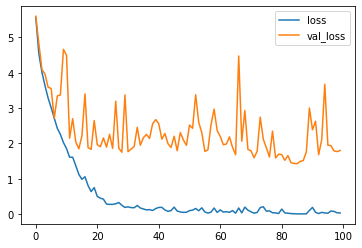

In [151]:
loss_history = pd.DataFrame(ResNet_history.history)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

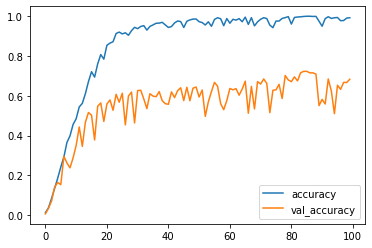

In [152]:
loss_history[['accuracy','val_accuracy']].plot()

### Mobile Net

In [ ]:
def Mobile_net():

  mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)

  model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(150, activation = 'softmax')])

  return model


In [ ]:
mobile_model = Mobile_net()
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
Mobilenet_history =  mobile_model.fit(train_ds, epochs=100, validation_data = val_ds, verbose=0)

In [ ]:
mobile_model.save_weights("./model_weight/resnet50.h5")

In [ ]:
hist_df = pd.DataFrame(Mobilenet_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
90,0.049683,0.986699,2.970287,0.622372
91,0.054890,0.981901,2.374935,0.671922
92,0.037723,0.988007,2.855090,0.619369
93,0.049908,0.986263,2.565777,0.682432
94,0.025508,0.991714,2.255033,0.696697
95,0.008390,0.998038,1.539652,0.779279
96,0.012993,0.996729,1.426656,0.806306
97,0.009362,0.996729,1.407399,0.803303
98,0.016463,0.996075,1.363471,0.792793
99,0.011817,0.995857,1.309916,0.813814


<AxesSubplot:>

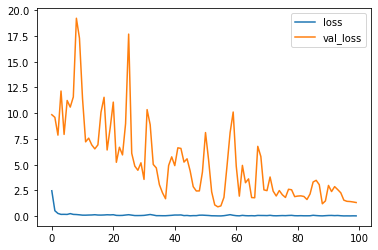

In [ ]:
loss_history = pd.DataFrame(Mobilenet_history.history)

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

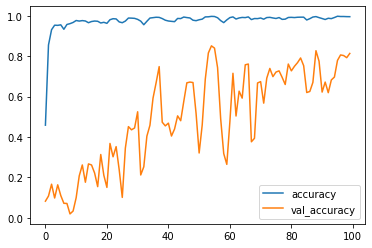

In [ ]:
loss_history[['accuracy','val_accuracy']].plot()

## Final Model

In [21]:
def Final_model():
  
  data_augmentation = tf.keras.Sequential(
        [
          layers.RandomZoom(0.3,0.3,fill_mode="nearest"),
          layers.RandomRotation(0.3)
        ]
    )
  
  mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)

  model = tf.keras.Sequential([
    data_augmentation,
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(150, activation = 'softmax')])

  return model

final_model = Final_model()
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

final_history =  final_model.fit(gan_train_ds, epochs=100, validation_data = val_ds, verbose=1)

Epoch 1/100
313/313 [==============================] - 80s 207ms/step - loss: 1.7576 - accuracy: 0.5893 - val_loss: 13.3813 - val_accuracy: 0.0622
Epoch 2/100
313/313 [==============================] - 74s 204ms/step - loss: 0.5900 - accuracy: 0.8351 - val_loss: 14.1966 - val_accuracy: 0.0839
Epoch 3/100
313/313 [==============================] - 75s 205ms/step - loss: 0.4313 - accuracy: 0.8786 - val_loss: 8.1804 - val_accuracy: 0.1768
Epoch 4/100
313/313 [==============================] - 76s 208ms/step - loss: 0.3541 - accuracy: 0.8968 - val_loss: 7.5719 - val_accuracy: 0.2457
Epoch 5/100
313/313 [==============================] - 75s 206ms/step - loss: 0.3043 - accuracy: 0.9086 - val_loss: 12.3702 - val_accuracy: 0.1228
Epoch 6/100
313/313 [==============================] - 76s 208ms/step - loss: 0.2760 - accuracy: 0.9179 - val_loss: 11.7022 - val_accuracy: 0.1333
Epoch 7/100
313/313 [==============================] - 75s 205ms/step - loss: 0.2442 - accuracy: 0.9260 - val_loss: 10.5

In [22]:
hist_df = pd.DataFrame(final_history.history) 
hist_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
90,0.040932,0.986817,1.039479,0.820974
91,0.030183,0.990512,0.849621,0.850936
92,0.040439,0.984620,1.635316,0.740824
93,0.040787,0.987017,1.120263,0.817228
94,0.041173,0.986817,0.788741,0.853933
95,0.032499,0.990013,0.761811,0.867416
96,0.031233,0.991611,0.829416,0.847191
97,0.033126,0.990412,0.792419,0.855431
98,0.031969,0.989813,0.887623,0.853933
99,0.030317,0.989713,1.012994,0.842697


<AxesSubplot:>

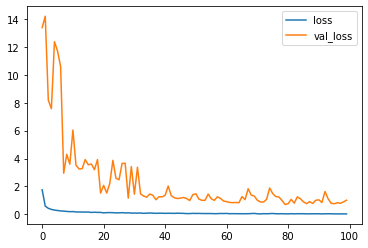

In [25]:
final_model.save_weights("./model_weight/baseline.h5")


loss_history = pd.DataFrame(final_history.history)
loss_history.to_csv('./history/final.csv')

loss_history[['loss','val_loss']].plot()

<AxesSubplot:>

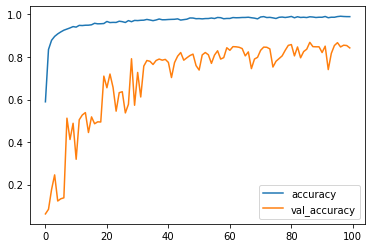

In [26]:
loss_history[['accuracy','val_accuracy']].plot()

In [27]:
def Final_model_lr():
      
  data_augmentation = tf.keras.Sequential(
        [
          layers.RandomZoom(0.3,0.3,fill_mode="nearest"),
          layers.RandomRotation(0.3)
        ]
    )
  
  mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)

  model = tf.keras.Sequential([
    data_augmentation,
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(150, activation = 'softmax')])

  return model


initial_rate = 0.001
decay_step = 200
decay_rate = 0.98

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_rate,
    decay_steps=decay_step,
    decay_rate=decay_rate,
    staircase=True)

final_model_lr = Final_model()
final_model_lr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

final_lr_history =  final_model_lr.fit(gan_train_ds, epochs=100, validation_data = val_ds, verbose=1)



Epoch 1/100
313/313 [==============================] - 85s 206ms/step - loss: 1.7032 - accuracy: 0.6108 - val_loss: 7.5861 - val_accuracy: 0.1431
Epoch 2/100
313/313 [==============================] - 73s 197ms/step - loss: 0.4942 - accuracy: 0.8605 - val_loss: 8.7621 - val_accuracy: 0.1551
Epoch 3/100
313/313 [==============================] - 73s 197ms/step - loss: 0.3562 - accuracy: 0.8947 - val_loss: 5.8557 - val_accuracy: 0.2891
Epoch 4/100
313/313 [==============================] - 73s 197ms/step - loss: 0.3048 - accuracy: 0.9079 - val_loss: 5.5329 - val_accuracy: 0.3169
Epoch 5/100
313/313 [==============================] - 75s 199ms/step - loss: 0.2459 - accuracy: 0.9291 - val_loss: 6.9557 - val_accuracy: 0.2697
Epoch 6/100
313/313 [==============================] - 74s 198ms/step - loss: 0.2271 - accuracy: 0.9343 - val_loss: 4.8213 - val_accuracy: 0.3835
Epoch 7/100
313/313 [==============================] - 73s 198ms/step - loss: 0.1940 - accuracy: 0.9405 - val_loss: 6.3561 -

In [28]:
final_model.save_weights("./model_weight/final_lr.h5")


loss_history = pd.DataFrame(final_lr_history.history)
loss_history.to_csv('./history/final_lr.csv')

<AxesSubplot:>

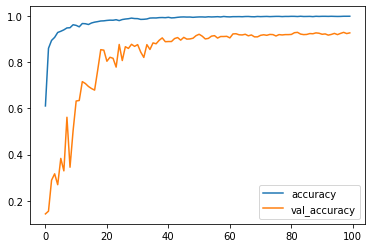

In [29]:
loss_history[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

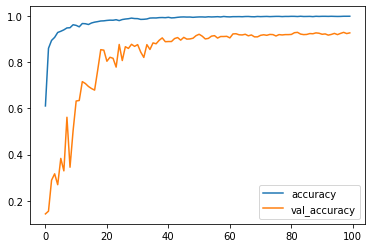

In [30]:
loss_history[['accuracy','val_accuracy']].plot()

# Overview

In [174]:
gan_df = pd.DataFrame(gan_history.history)
dropout_df = pd.DataFrame(Dropout_history.history)
reduct_df = pd.DataFrame(Reduct_history.history) 
decay_df = pd.DataFrame(Deacy_history.history) 
baseline_df = pd.DataFrame(baseline_history.history) 
Mobile_df = pd.DataFrame(Mobilenet_history.history) 
Resnet_df = pd.DataFrame(ResNet_history.history)

gan_df.to_csv('./history/gan.csv')
dropout_df.to_csv('./history/dropout.csv')
reduct_df.to_csv('./history/reduct.csv')
decay_df.to_csv('./history/decay.csv')
baseline_df.to_csv('./history/baseline.csv')
Mobile_df.to_csv('./history/Mobile.csv')
Resnet_df.to_csv('./history/Resnet.csv')

In [155]:
x = range(0, 30)
gan_train_acc = gan_df['accuracy']
reduct_train_acc = reduct_df['accuracy']
decay_train_acc = decay_df ['accuracy']
baseline_train_acc = baseline_df['accuracy']
dropout_train_acc = dropout_df['accuracy']
Mobile_train_acc = Mobile_df['accuracy']
Resnet_train_acc = Resnet_df['accuracy']

In [162]:
gan_val_acc = gan_df['val_accuracy']
reduct_val_acc = reduct_df['val_accuracy']
decay_val_acc = decay_df ['val_accuracy']
baseline_val_acc = baseline_df['val_accuracy']

dropout_val_acc = dropout_df['val_accuracy']

Mobile_val_acc = Mobile_df['val_accuracy']
Resnet_val_acc = Resnet_df['val_accuracy']

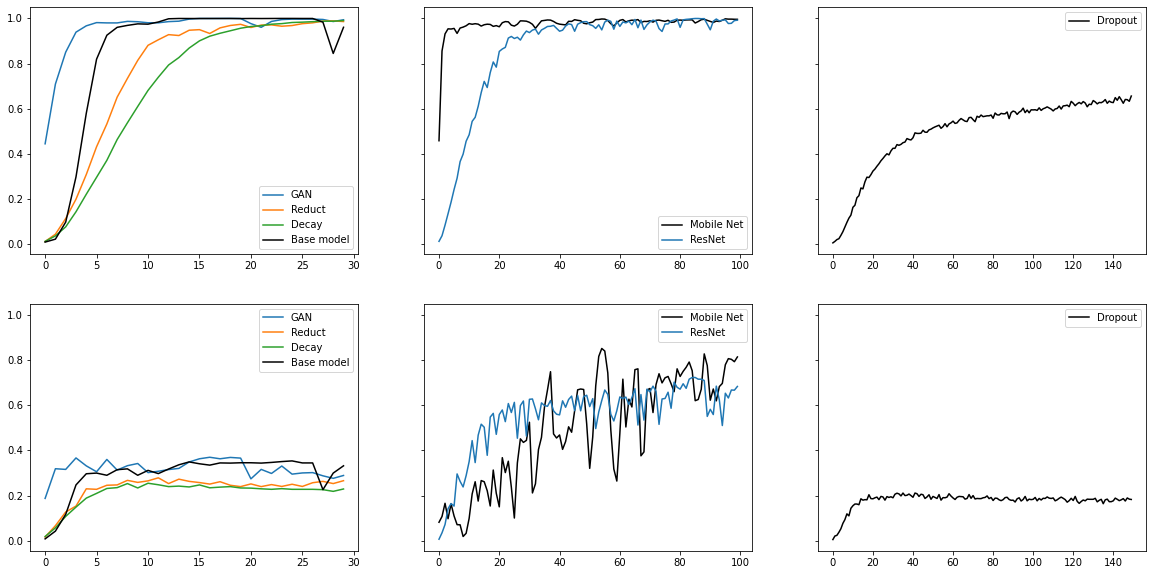

In [165]:
fig, axs = plt.subplots(2, 3, figsize=(20,10),sharey=True)

axs[0, 0].plot(x, gan_train_acc)
axs[0, 0].plot(x, reduct_train_acc)
axs[0, 0].plot(x, decay_train_acc)
axs[0, 0].plot(x, baseline_train_acc, 'black')
axs[0, 0].legend(["GAN", "Reduct", "Decay", "Base model"])

axs[0,2].plot(range(0, 150), dropout_train_acc, 'black')
axs[0,2].legend(["Dropout"])

axs[0,1].plot(range(0, 100), Mobile_train_acc, 'black')
axs[0,1].plot(range(0, 100), Resnet_train_acc)
axs[0,1].legend(["Mobile Net", "ResNet"])

axs[1, 0].plot(x, gan_val_acc)
axs[1, 0].plot(x, reduct_val_acc)
axs[1, 0].plot(x, decay_val_acc)
axs[1, 0].plot(x, baseline_val_acc, 'black')
axs[1, 0].legend(["GAN", "Reduct", "Decay", "Base model"])

axs[1, 2].plot(range(0, 150), dropout_val_acc, 'black')
axs[1, 2].legend(["Dropout"])

axs[1, 1].plot(range(0, 100), Mobile_val_acc, 'black')
axs[1, 1].plot(range(0, 100), Resnet_val_acc)
axs[1, 1].legend(["Mobile Net", "ResNet"])
plt.show()

In [168]:
gan_train_loss = gan_df['loss']
reduct_train_loss = reduct_df['loss']
decay_train_loss = decay_df ['loss']
baseline_train_loss = baseline_df['loss']
dropout_train_loss = dropout_df['loss']
Mobile_train_loss = Mobile_df['loss']
Resnet_train_loss = Resnet_df['loss']

In [166]:
gan_val_loss = gan_df['val_loss']
reduct_val_loss = reduct_df['val_loss']
decay_val_loss = decay_df ['val_loss']
baseline_val_loss = baseline_df['val_loss']

dropout_val_loss = dropout_df['val_loss']

Mobile_val_loss = Mobile_df['val_loss']
Resnet_val_loss = Resnet_df['val_loss']

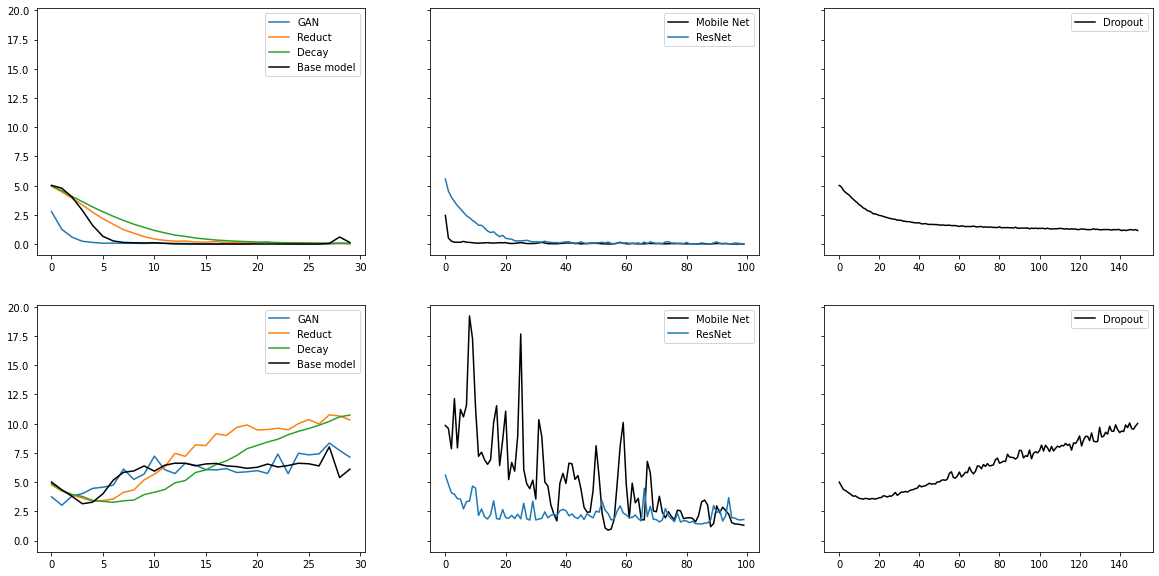

In [169]:
fig, axs = plt.subplots(2, 3, figsize=(20,10),sharey=True)

axs[0, 0].plot(x, gan_train_loss)
axs[0, 0].plot(x, reduct_train_loss)
axs[0, 0].plot(x, decay_train_loss)
axs[0, 0].plot(x, baseline_train_loss, 'black')
axs[0, 0].legend(["GAN", "Reduct", "Decay", "Base model"])

axs[0,2].plot(range(0, 150), dropout_train_loss, 'black')
axs[0,2].legend(["Dropout"])

axs[0,1].plot(range(0, 100), Mobile_train_loss, 'black')
axs[0,1].plot(range(0, 100), Resnet_train_loss)
axs[0,1].legend(["Mobile Net", "ResNet"])

axs[1, 0].plot(x, gan_val_loss)
axs[1, 0].plot(x, reduct_val_loss)
axs[1, 0].plot(x, decay_val_loss)
axs[1, 0].plot(x, baseline_val_loss, 'black')
axs[1, 0].legend(["GAN", "Reduct", "Decay", "Base model"])

axs[1, 2].plot(range(0, 150), dropout_val_loss, 'black')
axs[1, 2].legend(["Dropout"])

axs[1, 1].plot(range(0, 100), Mobile_val_loss, 'black')
axs[1, 1].plot(range(0, 100), Resnet_val_loss)
axs[1, 1].legend(["Mobile Net", "ResNet"])
plt.show()